сдравствуйте господин ревьюер код переносил из VS code но при переносе постоянно возникает проблема с библиотекой phik, можите подсказать как её решить.

также проблема возникает и в самом VS code, что только с раза 5-ого получается нормально загрузить библиотеку.

заранее спасибо! 😁✌️

## Порсонализация предложений для постоянных клиентов интернет магазина "В один клик"

### Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

### Задача проекта

Разработать решение, позволяющее персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Путь решения задачи

* Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
* В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
* Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

### Описание данных 

`market_file.csv` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

`market_money.csv` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

`market_time.csv` - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

`money.csv` - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

## Загрузка данных

In [ ]:
!pip install scikit-learn==1.1.3

In [ ]:
!pip install shap -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

!pip -q install phik



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score, classification_report

from sklearn.inspection import permutation_importance

import phik
import shap

RANDOM_STATE = 42
TEST_SIZE = 0.25


In [ ]:
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")
except:
    market_file = pd.read_csv('market_file.csv')
    market_money = pd.read_csv('market_money.csv')
    market_time = pd.read_csv('market_time.csv')
    money = pd.read_csv('money.csv', sep=';', decimal=",")

### Общие сведения датасетов

Проверим основную информацию по загруженным данным. Исправлять выявленные недостатки будем в дальнейших шагах проекта.

In [ ]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [ ]:
market_file.head(3)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [ ]:
market_file.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Столбцы датасета совпадают с описанием. Явных пропусков не видно. Названия некоторых столбцов содержат пробелы, что нужно будет исправить в дальнейшем. Тип данных некоторых столбцов, например `Маркет_актив_6_мес` и `Акционные_покупки` не совпадает с описанием.

In [ ]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [ ]:
market_money.head(3)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


In [ ]:
market_money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Столбцы датасета совпадают с описанием. Явных пропусков не видно. Тип данных столбца `Выручка` не совпадает с описанием. Кроме того есть записи с выручной 0 и с выручкой более 100 000. Выглядят подозрительно, проверим это в дальнейшем.

In [ ]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [ ]:
market_time.head(3)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


In [ ]:
market_time.describe()

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Столбцы датасета совпадают с описанием. Явных пропусков не видно. 

In [ ]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [ ]:
money.head(3)

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


In [ ]:
money.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Столбцы датасета совпадают с описанием. Явных пропусков не видно.

### Вывод

Все три датасета загрузулись без проблем из файлов. Разделителем строк оказалась запятая, но в файле `money.csv` это была точка с запятой.

## Предобработка данных

Теперь займемся предобработкой данных. Приведем в порядок наименования столбцов, приведем типы данных, поищем пропуски, опечатки, и дубли в данных.

### Переименование столбцов

Так как в рамках проекта позволено оставить киррилические наименование столбцов, то просто заменим пробелы на подчеркивания.

In [23]:
def columns_remove_spaces(df):
    df.columns = df.columns.str.replace(' ', '_').str.lower()

In [24]:
columns_remove_spaces(market_file)
columns_remove_spaces(market_money)
columns_remove_spaces(market_time)
columns_remove_spaces(money)

In [25]:
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

### Приведение типов данных

Некоторые колонки содержание численны данные были определены как `object` исправим это.

In [26]:
def object_to_float(df, columns):
    for col in columns:
        df[col] = df[col].astype('float64')

In [27]:
market_file.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [28]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [29]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


### Обработка дублей в данных

Проверим наличие полных дублей в датасетах.

In [30]:
market_file.duplicated().sum()

np.int64(0)

Полных дублей записей нет.

In [31]:
market_file[market_file.duplicated(subset=['покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'])]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
547,215895,Снизилась,стандарт,нет,4.4,5,517,0.23,Товары для детей,1,2,5,11
548,215896,Снизилась,стандарт,нет,4.3,4,460,0.16,Техника для красоты и здоровья,2,1,3,6
549,215897,Снизилась,стандарт,да,3.9,4,627,0.24,Товары для детей,3,3,7,8
550,215898,Снизилась,стандарт,да,5.5,4,703,0.14,Мелкая бытовая техника и электроника,2,1,3,7
551,215899,Снизилась,стандарт,нет,5.0,4,136,0.27,Товары для детей,3,4,4,17
552,215900,Снизилась,стандарт,да,4.8,4,907,0.30,Косметика и аксесуары,2,1,1,6
553,215901,Снизилась,стандарт,нет,3.9,5,600,0.17,Домашний текстиль,1,7,4,10
554,215902,Снизилась,стандарт,да,3.3,3,871,0.20,Техника для красоты и здоровья,2,4,2,17
555,215903,Снизилась,стандарт,да,5.6,5,574,0.28,Домашний текстиль,3,2,3,9
556,215904,Снизилась,премиум,да,5.5,5,982,0.94,Мелкая бытовая техника и электроника,3,1,8,10


Но вот если исключить ключевое поле `Id`, то есть 11 дублей. Пока что непонятно, что с ними делать. Пока что оставим как есть. Тем более что записей в датасете всего 1300 - не так уж и много.

В остальных датасетах нет смысла исключать поле Id, проверим только полные дубли.

In [32]:
print('Число дублей в датафрейме market_money', market_money.duplicated().sum())
print('Число дублей в датафрейме market_time', market_time.duplicated().sum())
print('Число дублей в датафрейме money', money.duplicated().sum())

Число дублей в датафрейме market_money 0
Число дублей в датафрейме market_time 0
Число дублей в датафрейме money 0


Ну что же полных дублей строк не найдено, уже хорошо.

### Обработка пропусков в данных

Ранее, при изучении общий сведений было замечено, что в данных нет явных пропусков. Но могу быть неявные. Будем рассматривать, только категроральные признаки, потому как пропуски в количественных признаках, а вернее нулевые значения будут выявлены в дальнейшем на шаге исследовательского анализа данных.

In [33]:
def check_string_nan_values(df, columns):
    columns_with_nan = {}
    for col in columns:    
        na_count = df[(df[col].str.lower().isin(['', ' ', 'none', 'nan']))][col].count()
        if na_count > 0:
            columns_with_nan[col] = na_count

    return columns_with_nan

In [34]:
cols = check_string_nan_values(market_file, market_file.select_dtypes(include=['object']).columns.to_list())
print('Список колонок market_file с пустыми значениями', cols)

Список колонок market_file с пустыми значениями {}


In [35]:
cols = check_string_nan_values(market_money, market_money.select_dtypes(include=['object']).columns.to_list())
print('Список колонок market_money с пустыми значениями', cols)

Список колонок market_money с пустыми значениями {}


In [36]:
cols = check_string_nan_values(market_time, market_time.select_dtypes(include=['object']).columns.to_list())
print('Список колонок market_time с пустыми значениями', cols)

Список колонок market_time с пустыми значениями {}


Похоже что датасеты не содержат неявных пропусков. 

### Вывод

На данном этапе исследования были проделаны следующие шаги.

* Переименовывание колонок. Так как в данном проекте позволяется использовать кириллические название колонок, то была только произведена замена пробелов, на землю.
* Приведение типов. Многие колонки, которые содержит численные значения были отмечены не числовими типами данных. Исправили это, теперь все верно.
* Обработка дублей. Явных дублей данных не обнаружено. Датафрейм market_file содержит 11 дублей записей, но пока что было решено их оставить.
* Обработка пропусков. Были исследованы только категоральные признаки. И как оказалось в таких колонках нет явных и неявных пропусков.Количественные признаки будут исследованы на следующем этапе исследования.

## Исследовательский анализ данных

**market_file**

Теперь займемся исследованием данных. Проверим данные на выбросы и аномальные значения, а так проверим не ускальзнули от нас ли какие-либо ошибки в данных.

In [37]:

    
def histogram(df, col, target):
    plt.figure(figsize=(8,6))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_ylabel('Количество', fontsize=14)
    
    
def categoral_unique(df, col):
    display(df[col].unique())
    
    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)
    
    
def hist_with_wiskers(df, col, target):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Гистограмма для {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    if target != None:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    else:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
    axes[1].set_title(f'График ящик с усами для {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    plt.show()

def pivot_bar_plot(df, col):
    plt.figure(figsize=(8,6))
    plot = sns.barplot(x=col, data=df, y=df.index)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)
    
def plot_feature_distribution(df, col, target=None, max_unique=20):
    """
    Визуализация распределения признака.
    Если признак дискретный (целые числа и мало уникальных значений) — countplot.
    Если признак непрерывный — histplot + boxplot.
    """
    unique_vals = df[col].dropna().nunique()
    is_integer = pd.api.types.is_integer_dtype(df[col])
    is_discrete = is_integer and unique_vals <= max_unique
    
    if is_discrete:
        plt.figure(figsize=(8,6))
        sns.countplot(data=df, x=col, hue=target)
        plt.title(f'Countplot для {col}')
        plt.show()
    else:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        sns.histplot(data=df, x=col, hue=target, kde=True, ax=axes[0])
        axes[0].set_title(f'Гистограмма для {col}')
        sns.boxplot(data=df, y=col, ax=axes[1])
        axes[1].set_title(f'Ящик с усами для {col}')
        plt.show()


array(['Снизилась', 'Прежний уровень'], dtype=object)

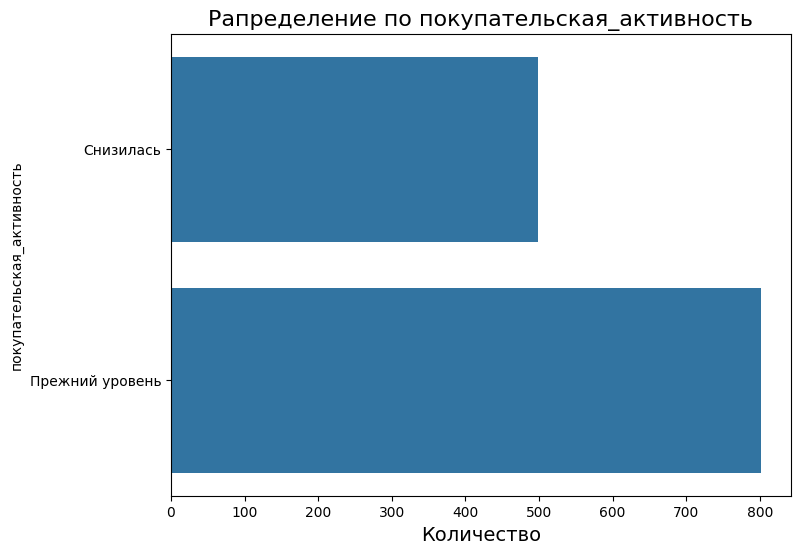

In [38]:
categoral_unique(market_file, 'покупательская_активность')

Видим некоторый дисбаланс значений в целевом признаке, это нужно будет учесть в модели.

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

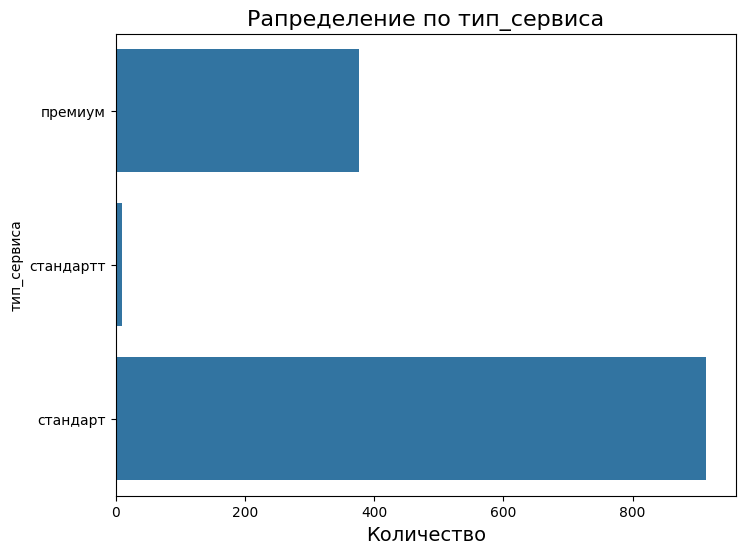

In [39]:
categoral_unique(market_file, 'тип_сервиса')

Обнаружилась опечатка.  
Так же обратим внимание, что премиум пользователей меньше, что и логично.

In [40]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

array(['да', 'нет'], dtype=object)

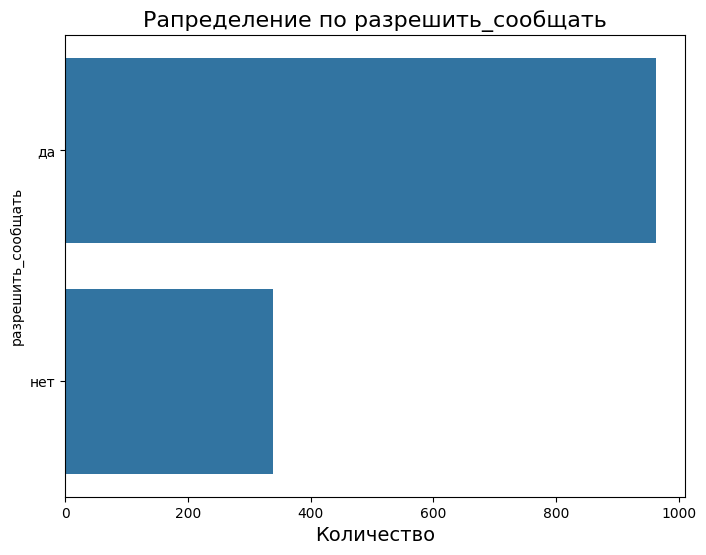

In [41]:
categoral_unique(market_file, 'разрешить_сообщать')

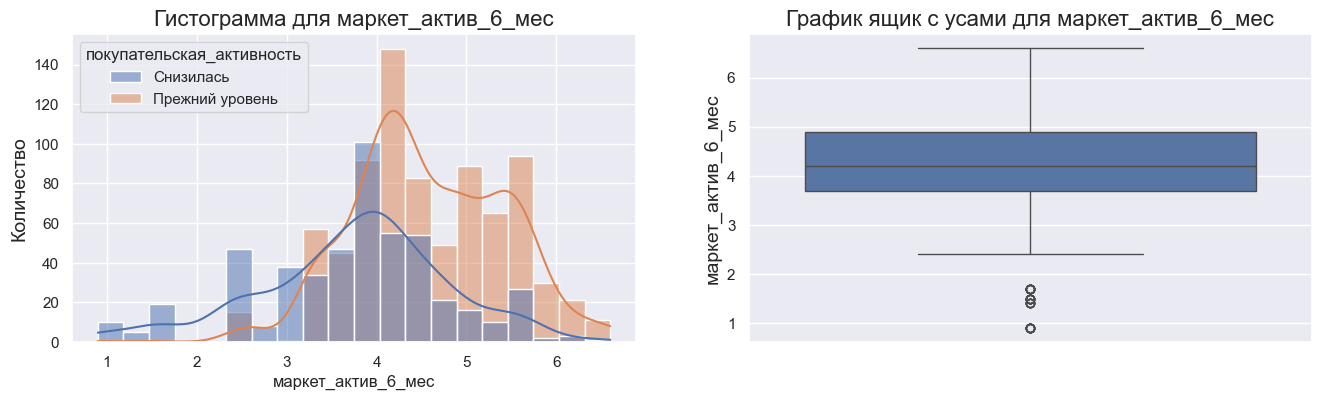

In [42]:
hist_with_wiskers(market_file, 'маркет_актив_6_мес', 'покупательская_активность')

In [43]:
market_file.query('маркет_актив_6_мес < 2')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
30,215378,Снизилась,стандарт,да,1.7,3,488,0.39,Техника для красоты и здоровья,5,1,4,3
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7
38,215386,Снизилась,стандарт,да,1.5,3,495,0.98,Домашний текстиль,2,3,7,5
47,215395,Снизилась,премиум,да,1.5,5,645,0.27,Товары для детей,3,3,6,5
55,215403,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
61,215409,Снизилась,премиум,да,1.4,4,857,0.95,Кухонная посуда,3,4,5,5
63,215411,Снизилась,стандарт,да,1.7,4,756,0.33,Товары для детей,2,3,7,4
70,215418,Снизилась,стандарт,нет,1.7,4,472,0.94,Домашний текстиль,2,6,4,3
81,215429,Снизилась,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4
108,215456,Снизилась,стандарт,да,1.7,4,449,0.23,Косметика и аксесуары,3,4,4,5


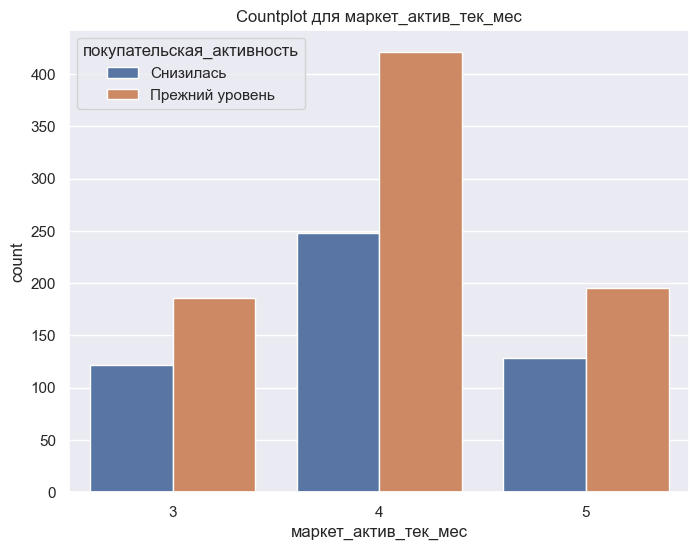

In [44]:
plot_feature_distribution(market_file, 'маркет_актив_тек_мес', 'покупательская_активность')

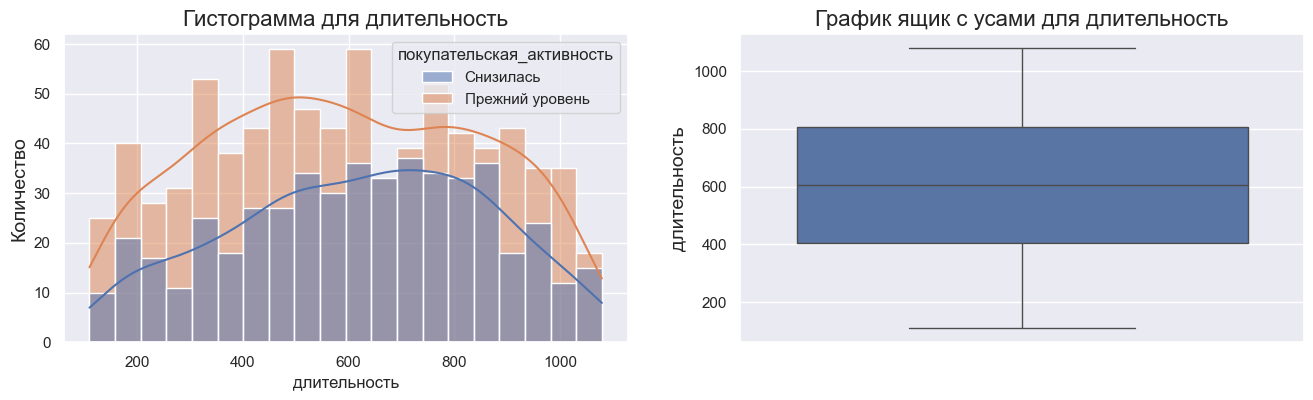

In [45]:
hist_with_wiskers(market_file, 'длительность', 'покупательская_активность')

Все выглядит хорошо.

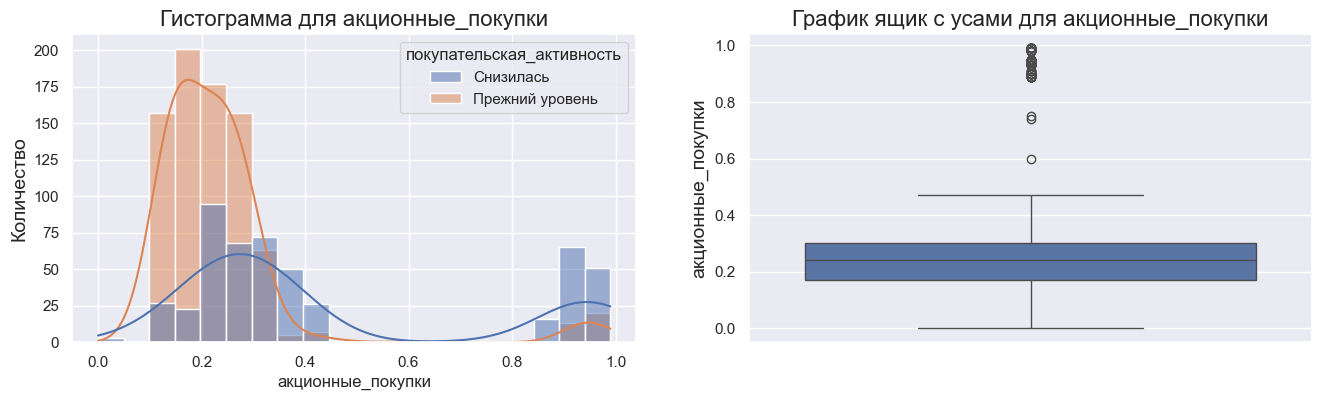

In [46]:
hist_with_wiskers(market_file, 'акционные_покупки', 'покупательская_активность')

Очень выглядит так, что большинство покупателей не ориентируются на скидки. Но тем не менее есть существенная часть клиентов, которые отлеживают скидки. Поэтому подготовке данных для модели разумным будет разделить пользователей на две части `Часто покупает по акции` и `Редко покупает по акции`, превратив колонку `Акционные_покупки` в категоральный признак.

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

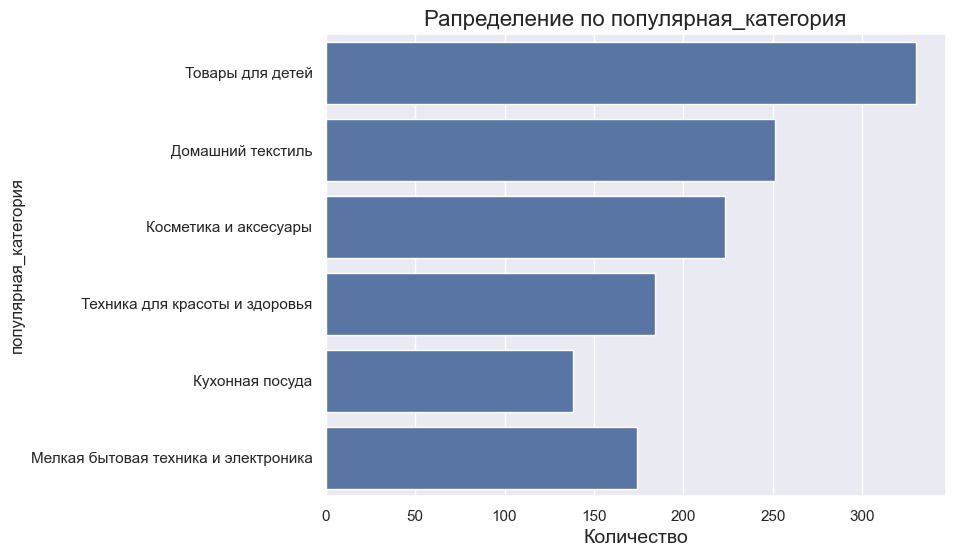

In [47]:
categoral_unique(market_file, 'популярная_категория') 

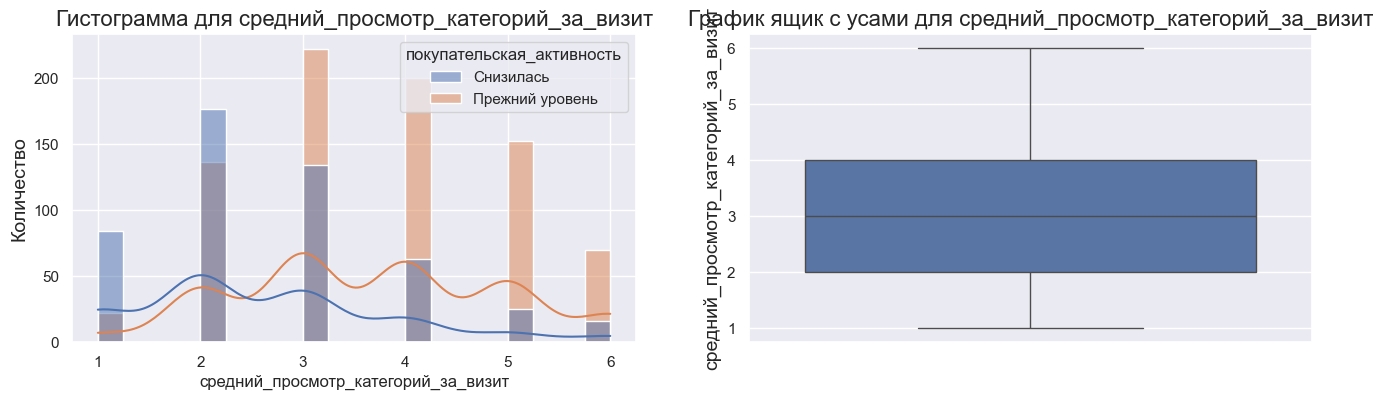

In [48]:
hist_with_wiskers(market_file, 'средний_просмотр_категорий_за_визит', 'покупательская_активность')

Все выглядит хорошо.

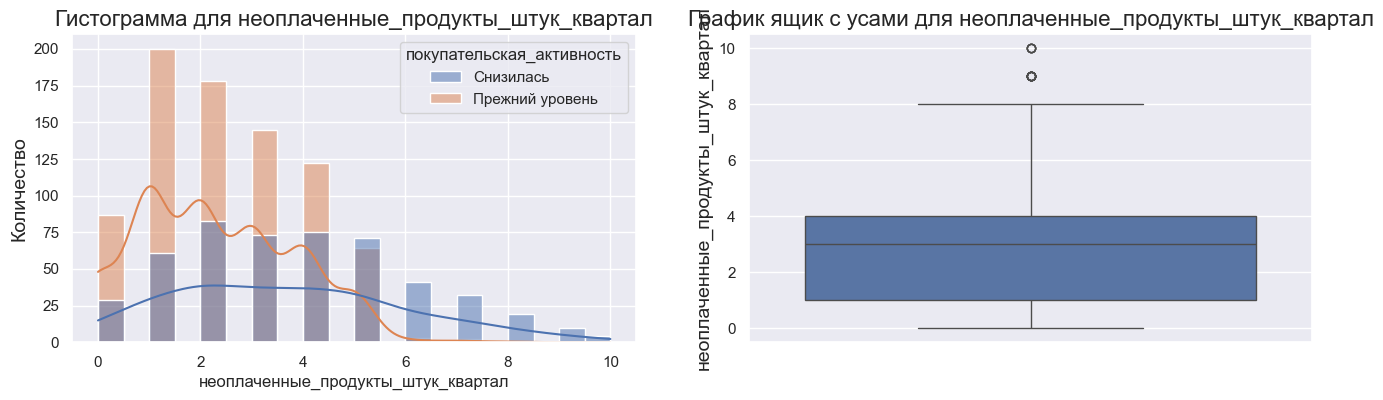

In [49]:
hist_with_wiskers(market_file, 'неоплаченные_продукты_штук_квартал', 'покупательская_активность')

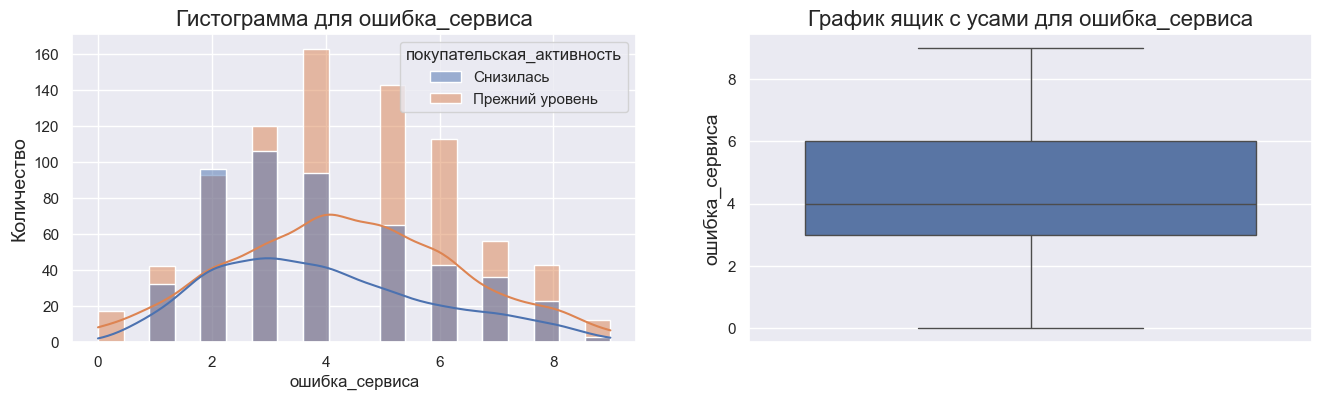

In [50]:
hist_with_wiskers(market_file, 'ошибка_сервиса', 'покупательская_активность')

Ммм сайт крашится в среднем всего-то 4 раза за одно посещение))))

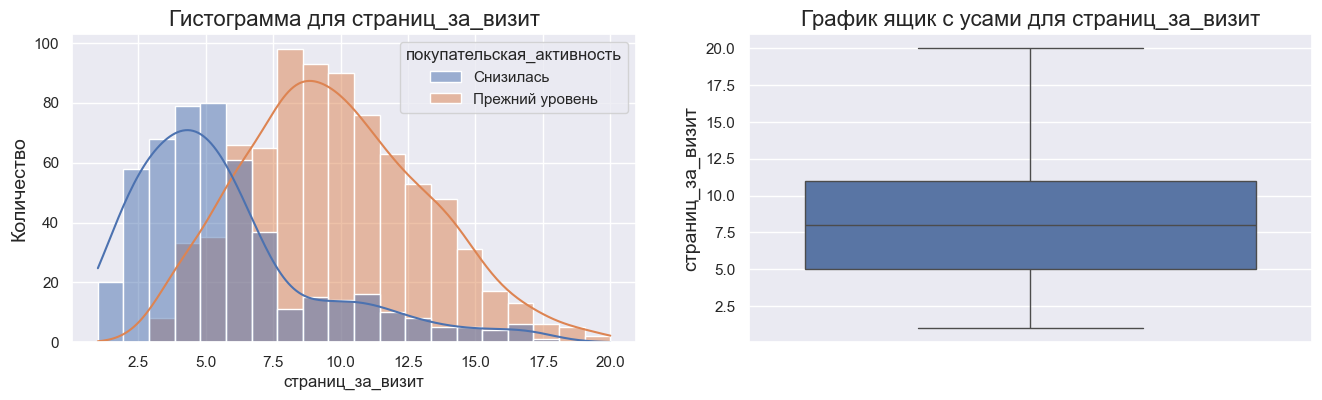

In [51]:
hist_with_wiskers(market_file, 'страниц_за_визит', 'покупательская_активность')

Все выглядит хорошо.

**market_money**

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

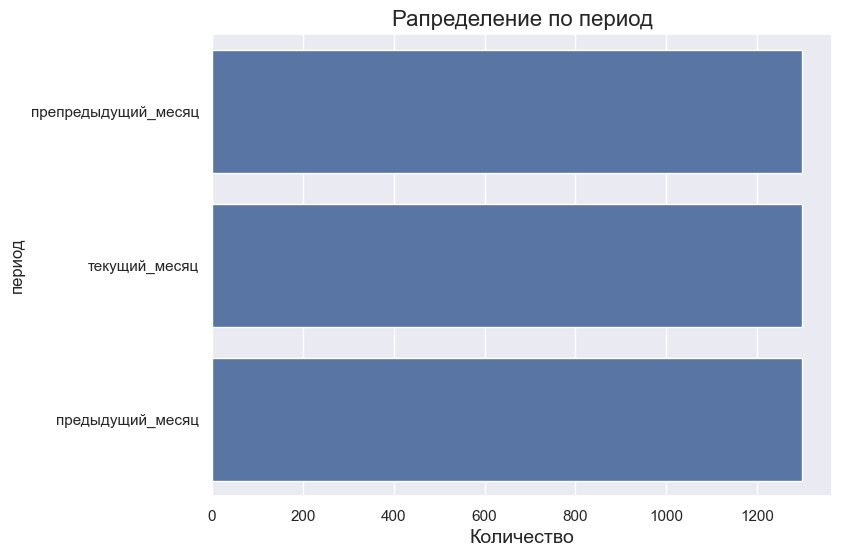

In [52]:
categoral_unique(market_money, 'период') 

In [53]:
market_money_by_period = market_money.pivot_table(index='период', values=['выручка'], aggfunc='sum')
market_money_by_period

,выручка
период,
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0
текущий_месяц,6909449.1


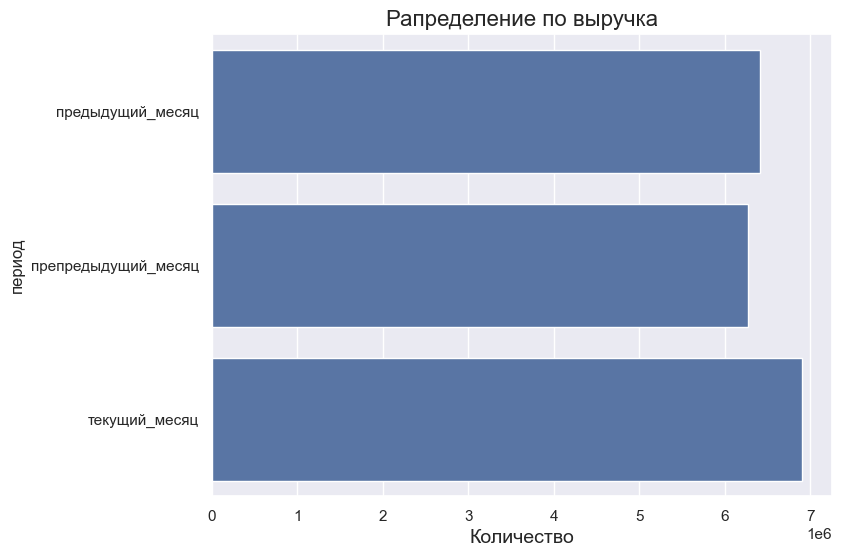

In [54]:
pivot_bar_plot(market_money_by_period, 'выручка') 

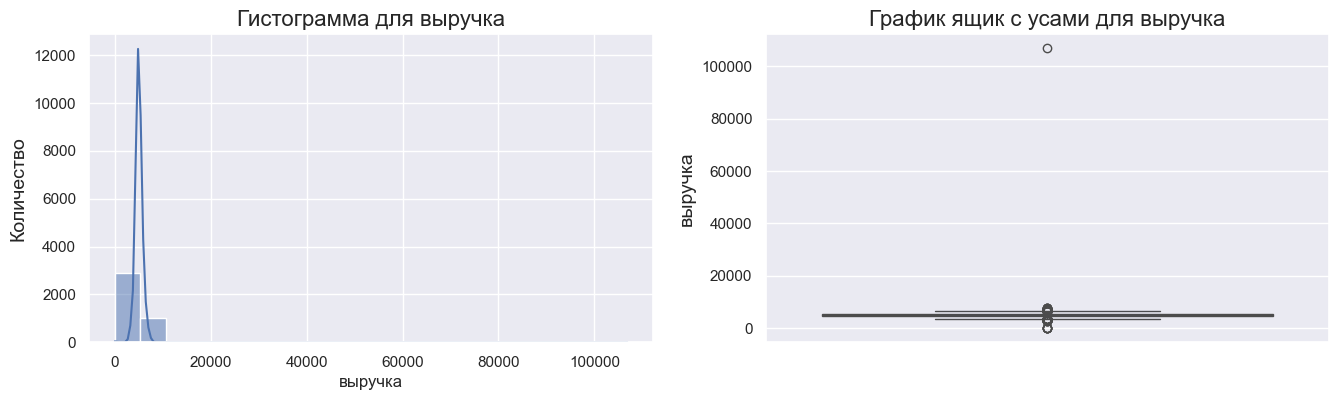

In [55]:
hist_with_wiskers(market_money, 'выручка', None)

In [56]:
market_money.query('выручка > 100000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


Явно выброс, от которого стоит избавиться.

In [57]:
market_money = market_money[market_money['выручка'] < 100000]

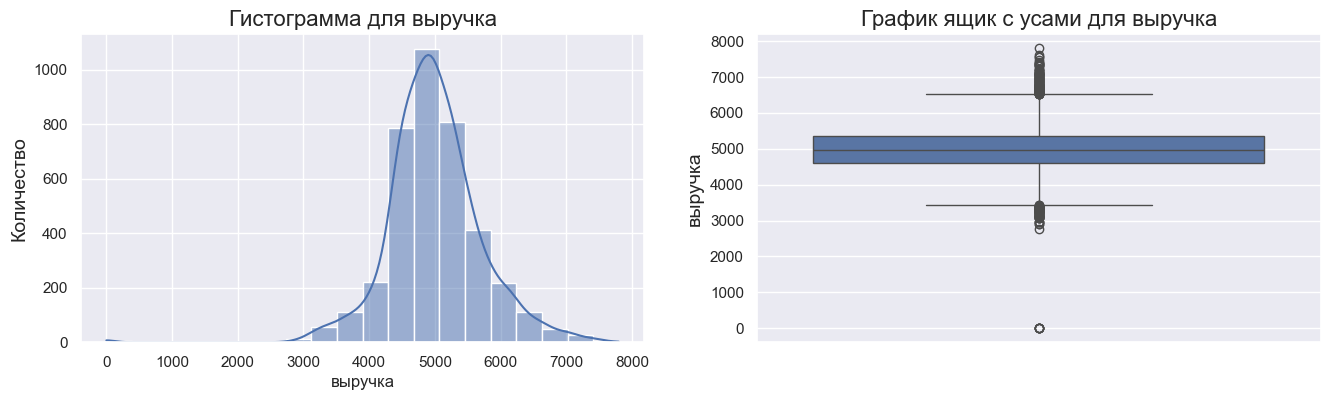

In [58]:
hist_with_wiskers(market_money, 'выручка', None)

In [59]:
market_money.query('выручка < 1')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Периодов с нулевой выручкой. Это плохие записи, потому что мы хотим в дальнейшем использовать только тех пользователей, у которых есть активность за три месяца, а такие пустые записи явно нам помешают.

In [60]:
market_money = market_money[market_money['выручка'] > 0]

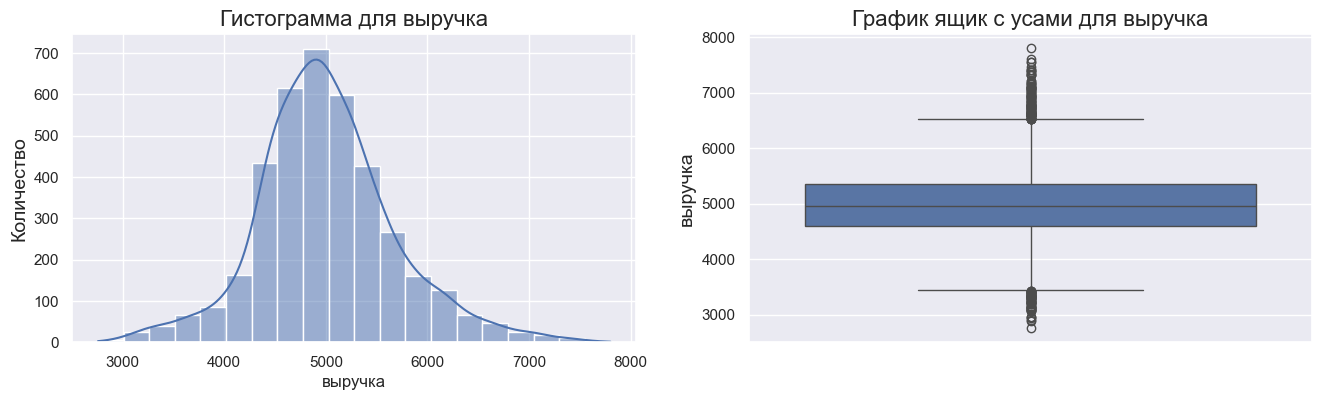

In [61]:
hist_with_wiskers(market_money, 'выручка', None)

Перфекто.

**market_time**

In [62]:
market_time_by_period = market_time.pivot_table(index='период', values=['минут'], aggfunc='sum')
market_time_by_period

,минут
период,
предыдцщий_месяц,17508
текущий_месяц,17166


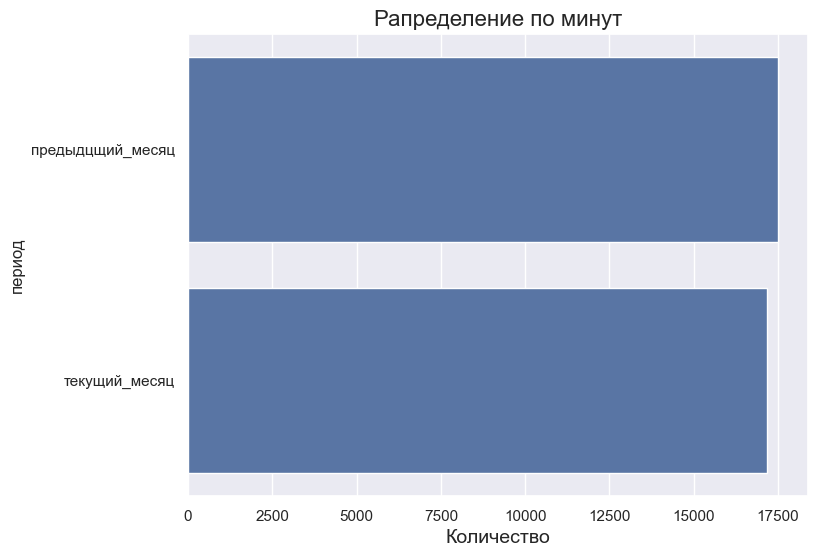

In [63]:
pivot_bar_plot(market_time_by_period, 'минут') 

А вот и опечатка.

In [64]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


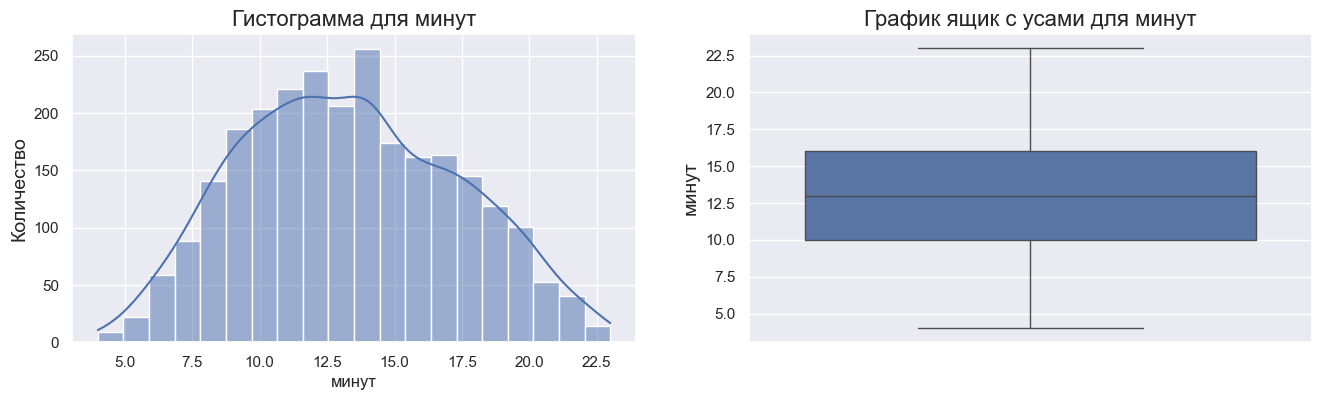

In [65]:
hist_with_wiskers(market_time, 'минут', None)

**money**

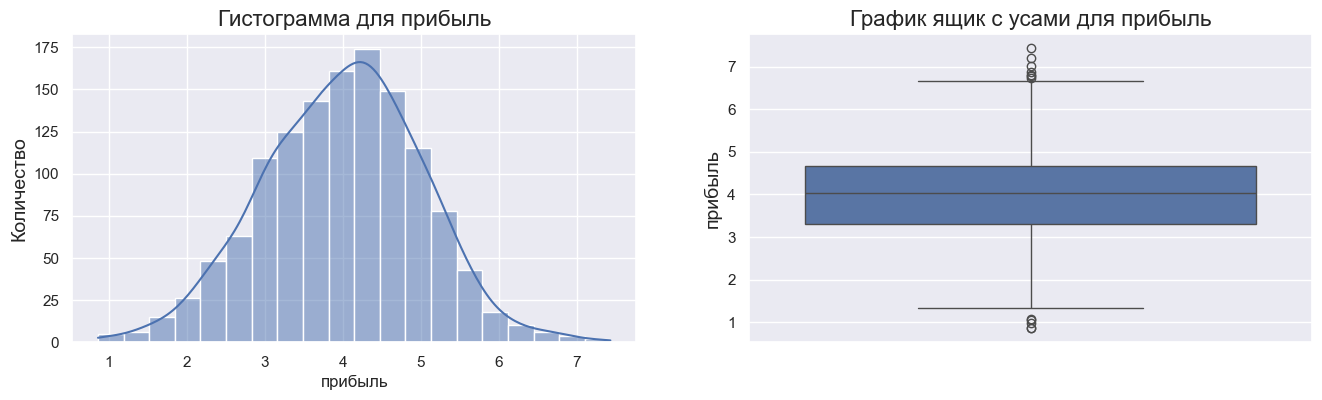

In [66]:
hist_with_wiskers(money, 'прибыль', None)

### Выбор активных пользователей

После того как мы исселодовали данные, нужно отобрать клиентов с активностью не менее трех месяцов. Это значит, что нам нужны записи из `market_money`, где у клиента есть покупки за все три периода `'препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'`.

In [67]:
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market_file = market_file[market_file['id'].isin(grouped.index)]
len(market_file)

1296

Отфильтровалось всего 4 записи. 

### Вывод

На данном этапе был проведен исследовательский анализ данных. В ходе работы были исправлены опечатки в данных, которые удалось хорошо найти по составленным графикам. Так же было выявлено небольшое количество явно аномальных значений, которые были отброшены из рассмотрения. В целом данные выглядят хорошо. Так же оставили только пользователей, совершавших покупки в течении трех последних месяцев.

## Объединение таблиц

Теперь объеденим данные из датафреймов `market_file`, `market_money`, `market_time` в одну таблицу.

In [68]:
market_money_grouped = market_money.pivot_table(index=['id'], columns=["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

market_time_grouped = market_time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

market_full = market_file.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)
market_full.head(5)

ValueError: The column label 'id' is not unique.

### Вывод

Теперь после объеденения датасетов все характеристики в одной таблице.

## Корреляционный анализ

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


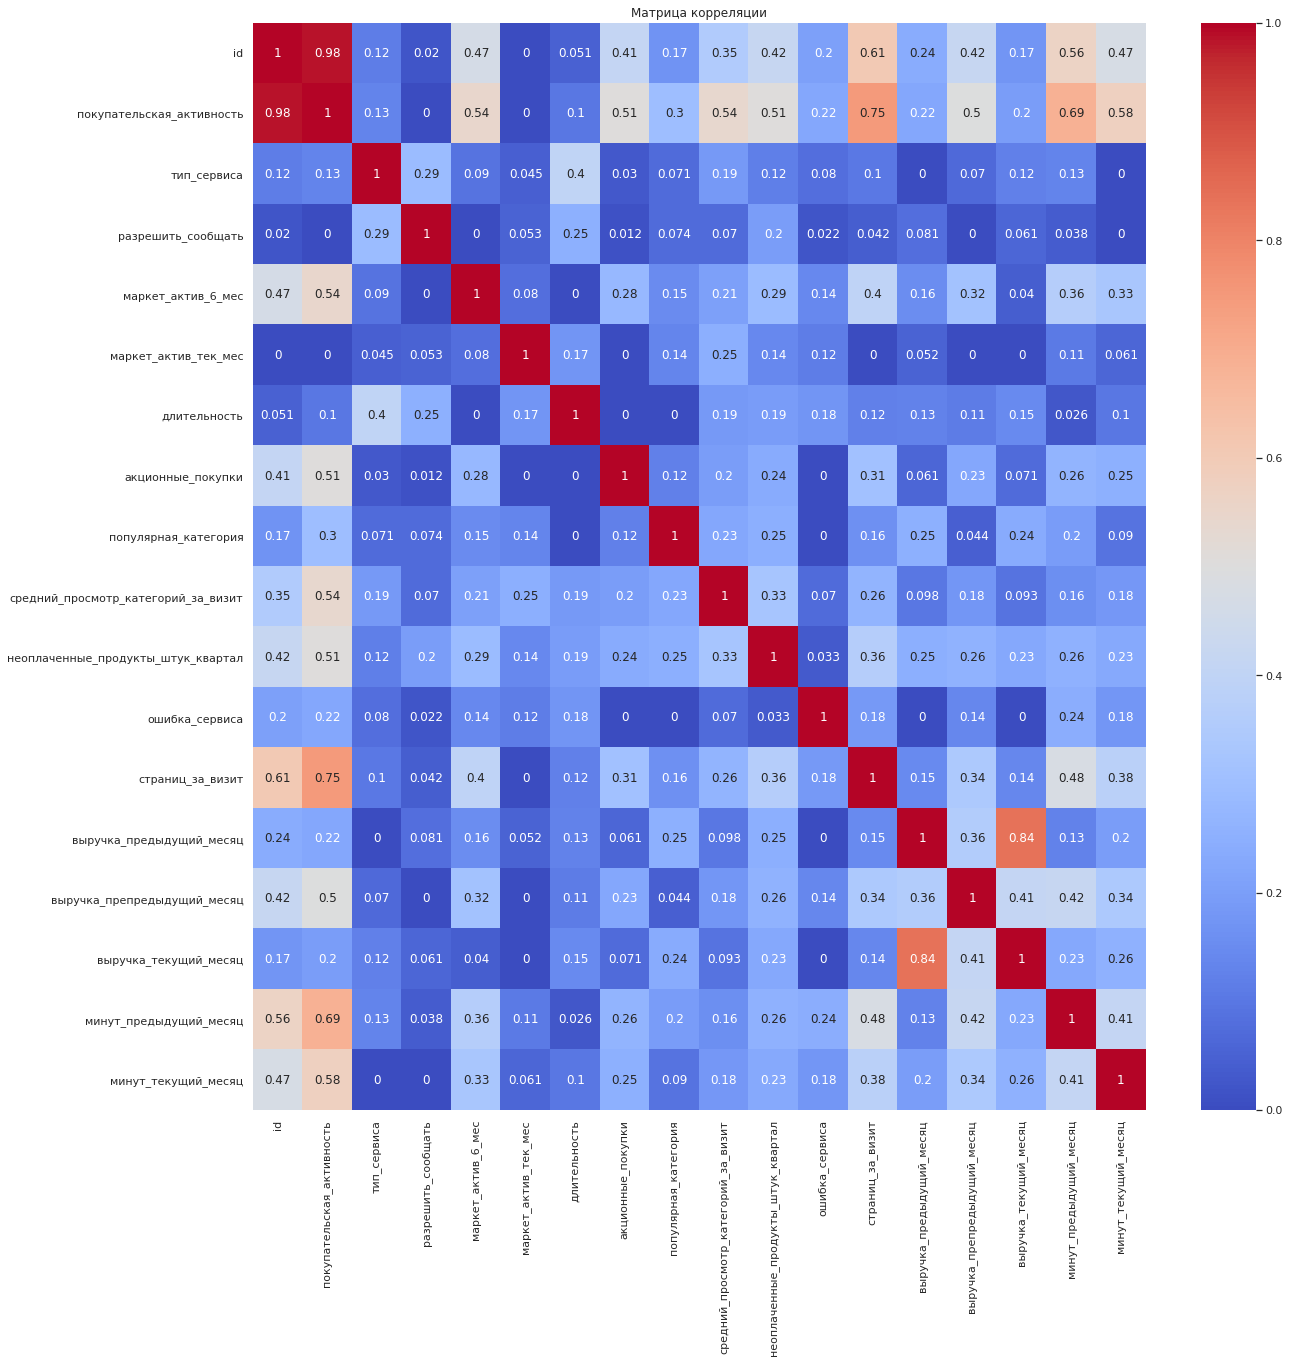

In [ ]:
corr_matrix = market_full.phik_matrix()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

Так же построим матрицы корреляции для значений целевого признака отдельно.

In [ ]:
def build_phik_corr_matrix(df, col):
    ax_col = 0
    ax_row = 0
    
    fig, axs = plt.subplots(ncols=1, nrows=df[col].nunique(), figsize=(20,20))
    for i in df[col].unique():
        df_i = df[df[col] == i]
        sns.heatmap(df_i.phik_matrix(), annot=True, cmap='cividis', ax=axs[ax_col])
        axs[ax_col].set_title(i)
        ax_col+=1
        if ax_col > 1:
            ax_col=0
            ax_row+=1  
    fig.tight_layout()
    plt.show()

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']
interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


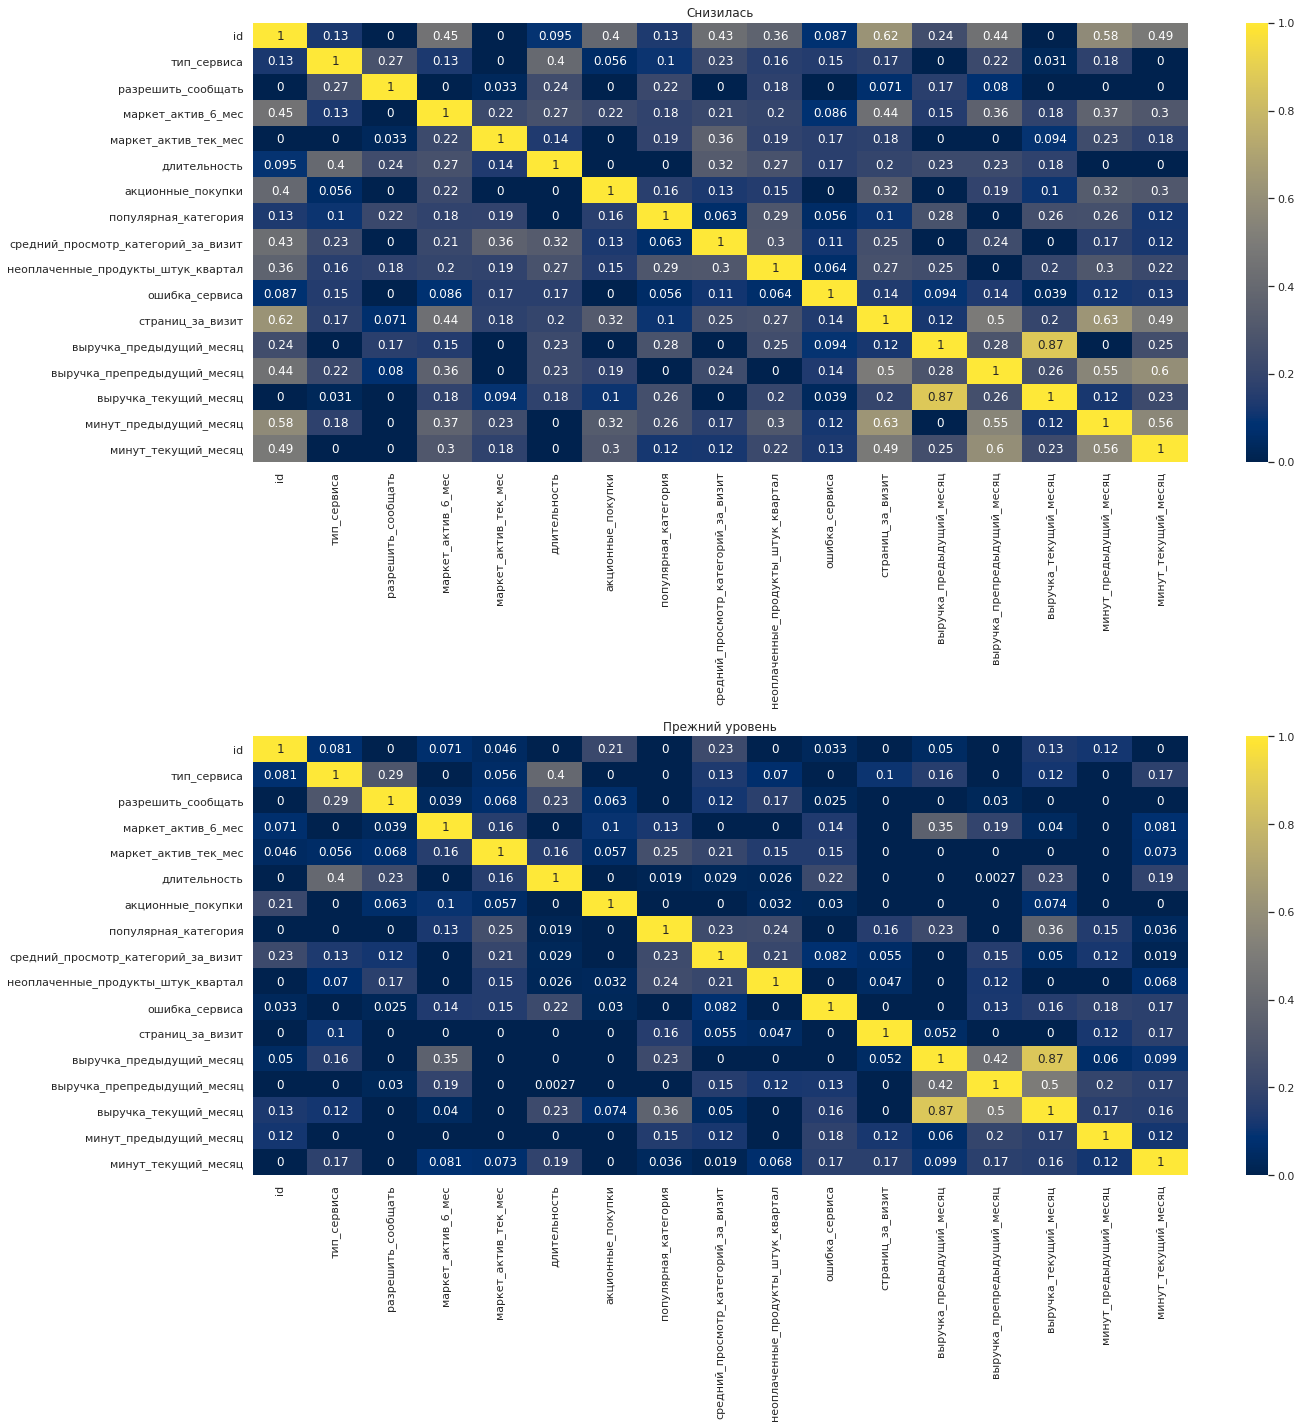

In [ ]:
build_phik_corr_matrix(market_full, 'покупательская_активность')

### Вывод

Целевым признаком является `Покупательская_активность` и вот список полей, которые имеют хоть корреляцию с ним: `Маркет_актив_6_мес`, `Акционные_покупки`, `Средний_просмотр_категорий_за_визит`, `Неоплаченные_продукты_штук_квартал`, `Страниц_за_визит`, `Выручка_препредыдущий_месяц`, `минут_предыдущий_месяц`, `минут_текущий_месяц`.  
Среди признаков замечана только одна более менее сильная корреляция `Выручка_предыдущий_месяц`, `Выручка_текущий_месяц`. Но значение корреляции меньше 0.9 поэтому не будем удалять признаки.  
Так же график показывает странную корреляцию `Покупательская_активность` и `id`, так что `id` так же уберем из датасета и так как он нам еще понадобиться то превратим его в индекс датасета.

## Использование пайплайнов

Приступим к непосредственному построению модели. Мы переберем модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC() используя пайплайны.  


Подготовим данные. Закодируем целевой признак в значение 0 и 1. А так же превратим колонку `Акционные_покупки` в категоральный признак.

In [ ]:
market_full['покупательская_активность'] = market_full['покупательская_активность']\
.apply( lambda x: 1 if x=='Снизилась' else 0 )
market_full['покупательская_активность'] = market_full['покупательская_активность'].astype(int)    

In [ ]:
market_full['акционные_покупки_категория'] = market_full['акционные_покупки']\
.apply( lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' )
market_full = market_full.drop(['акционные_покупки'], axis=1)

In [ ]:
market_full = market_full.set_index('id')

In [ ]:
market_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.4,4,819,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,Часто покупает по акции
215350,1,стандарт,нет,4.9,3,539,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,Редко покупает по акции
215351,1,стандарт,да,3.2,5,896,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,Часто покупает по акции
215352,1,стандарт,нет,5.1,3,1064,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,Часто покупает по акции
215353,1,стандарт,да,3.3,4,762,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,Редко покупает по акции


In [ ]:
# X = market_full.drop(['Покупательская_активность'], axis=1)
X = market_full.drop(['покупательская_активность'], axis=1)
y = market_full['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [ ]:
X_train.head()

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,Редко покупает по акции


In [ ]:
ohe_columns = ['разрешить_сообщать', 'популярная_категория', 'тип_сервиса']
ord_columns = ['акционные_покупки_категория']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'маркет_актив_тек_мес', 
               'длительность', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
               'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
               'минут_предыдущий_месяц', 'минут_текущий_месяц']

In [ ]:
ohe_pipe = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
)


In [ ]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                                      ['Редко покупает по акции','Часто покупает по акции']],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [ ]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория',
                                                                                'тип_сервиса']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                        {'models': [LogisticRegression(C=1,
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [ ]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория',
                                                   'тип_сервиса']),
                                         

In [ ]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')

Метрика ROC-AUC на тестовой выборке: 0.92


In [ ]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')

Метрика F1-score на тестовой выборке: 0.89


### Вывод

На данном шаге исследования была найдена и обучена модель для определения снижения активности покупателей сервиса. Лучшие результаты показала модель `LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')`. Метрика roc_auc для тестовой выборки показла результат 0.90, для тестовой выборки 0.89. Показатели очень хорошие, наша модель хорошо справляется с предсказанием. Так же метрика f1 показала и вовсе фантастические 0.90.  
У нас имеется дисбаланс в классах и все же он не помешал на получить такие высокие метрики.

<div class="alert alert-info"> <b>Комментарии студентаV2:</b> Мы использовали `roc_auc` как основную метрику подбора гиперпараметров, 
так как она устойчива к дисбалансу классов и показывает способность модели 
разделять классы независимо от порога.  

Однако для бизнес-задачи важнее **Recall на классе "снизилась"**, 
так как пропуск уходящего клиента ведёт к прямым потерям. 
Precision менее критичен: ложноположительных клиентов можно включить 
в рассылку без больших издержек.  

Таким образом:
- Для выбора гиперпараметров использован `roc_auc`.
- Для бизнес-интерпретации дополнительно анализируем `Recall` и `Precision` на классе "снизилась".
 </div>

## Анализ важности признаков

Ошибка при построении графиков SHAP: set_ticks() got an unexpected keyword argument 'fontsize'
Попробуйте использовать summary_plot вместо этого:


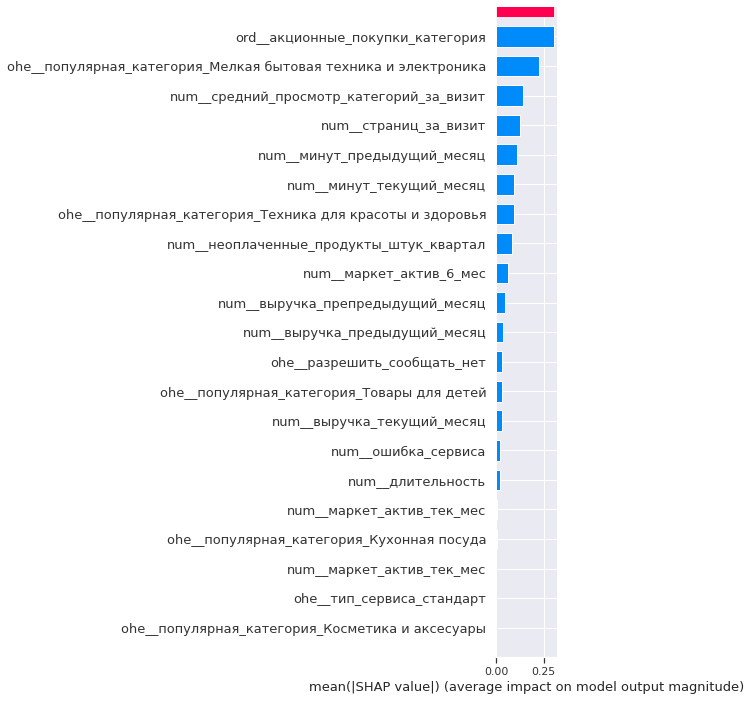

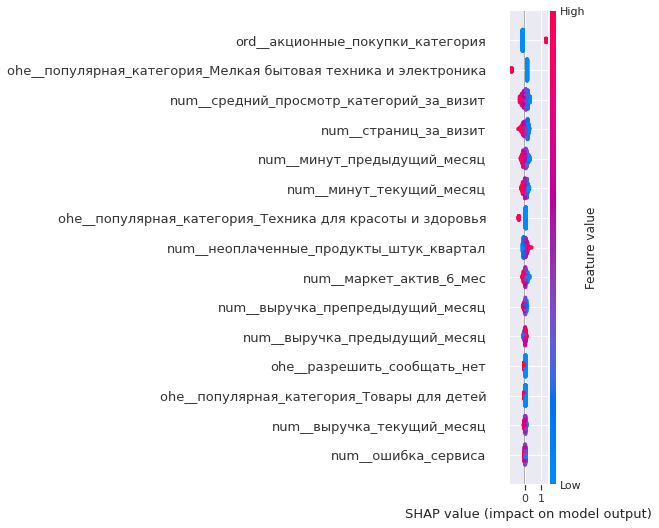

In [ ]:
import matplotlib.pyplot as plt
import warnings

try:
    X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
    explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

    X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

    # Безопасное получение имен признаков
    try:
        feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
        X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)
    except:
        X_test_2 = pd.DataFrame(X_test_2, columns=[f"feature_{i}" for i in range(X_test_2.shape[1])])

    # Вычислите SHAP значения
    shap_values = explainer(X_test_2)
    
    # Отображение графиков с обработкой ошибок
    try:
        # Bar plot
        fig, ax = plt.subplots(figsize=(12, 10))
        shap.plots.bar(shap_values, max_display=30, show=False)
        plt.title("SHAP Feature Importance - Bar Plot")
        plt.tight_layout()
        plt.show()
        
        # Beeswarm plot
        fig, ax = plt.subplots(figsize=(12, 8))
        shap.plots.beeswarm(shap_values, max_display=15, show=False)
        plt.title("SHAP Feature Importance - Beeswarm Plot")
        plt.tight_layout()
        plt.show()
        
    except Exception as plot_error:
        print(f"Ошибка при построении графиков SHAP: {plot_error}")
        print("Попробуйте использовать summary_plot вместо этого:")
        
        # Альтернатива с summary_plot
        shap.summary_plot(shap_values.values, X_test_2, max_display=30, plot_type="bar")
        plt.show()
        
        shap.summary_plot(shap_values.values, X_test_2, max_display=15)
        plt.show()

except Exception as e:
    print(f"Общая ошибка: {e}")
    import traceback
    traceback.print_exc()

<div class="alert alert-info"> <b>Комментарии студентаV2:</b> На графике beeswarm видно, что:

- `страниц_за_визит`: чем больше страниц за визит (красные точки справа), тем меньше вероятность снижения активности (SHAP отрицательный). Низкие значения признака (синие точки) наоборот увеличивают риск снижения.
- `средний_просмотр_категорий`: высокий просмотр категорий связан с удержанием клиентов (SHAP отрицательный), низкий — с риском снижения.
- `неоплаченные_товары`: чем больше брошенных корзин (красные справа), тем выше вероятность снижения активности (SHAP положительный).
- `акционные_покупки_категория`: частые покупки по акциям тоже могут увеличивать вероятность снижения (возможно, такие клиенты менее лояльны без скидок).
- `тип_сервиса`: премиум-сервис ассоциирован со снижением риска (точки уходят влево).

Таким образом, SHAP-анализ подтвердил гипотезы: активное использование сайта (много страниц, просмотр категорий) снижает риск ухода, а поведение, связанное с акциями и брошенными товарами — увеличивает.

 </div>

Получилось что пять самыйх важных для модели признаков это: `Страниц_за_визит`, `Средний_просмотр_категорий_за_визит`, `мин_предыдущий_месяц`, `мин_текущий_месяц`, `неоплаченный_продукты_штук_квартал`. И я вспоминая свое поведение на маркетплейсах могу принять такой выбор признаков. Чем больше пролистаешь страниц те больше вероятность что найдешь нужный товар. Кроме того при поиске той самой модели продукта постоянно добавляешь в корзину интересные находки и в итоге покупаешь только что-то одно.  
Малозначимыми признаками оказались:`Популярная категория`(кроме бытовой техники), `Маркет_актив_тек_мес`, `Разрешить сообщать`, `Тип_сервиса`, `Выручка_текущий_месяц`, `Длительность`, `Ошибка_сервиса`, `Выручка_предыдущий_месяц`.
И тут так же могу согласиться почти со всеми решениями модели. Мы рассматривем только активных покупателей. Значит и дата регистрации и падающие ошибки не так и важны. Сомнение у меня вызывает только Тип сервиса. Ладно премиум пользователи, они в моем представлении должны постоянно покупать бытовуху и расходники что бы в премиуме был смысл, но вот стандартные пользователи они менее постоянны. Странно что модель не посчитала это значимым признаком.

## Сегментация покупателей

Следующей задачей исследования является выделение какого либо сегмента пользователей и анализа поседения пользователей из этого сегмента. С целью составления рекомендации для заказчика, как увеличить активность данного сегмента.  
Признаться как среднестатестический пользователь маркетплейса я не очень понимаю как можно строить какие либо предсказания вокруг человека и анализировать его свободную волю.
Изначально я не знал какой сегмент выбрать поэтому решил сначала построить диграмму рассеяния Прибыли и Вероятности снижения активности пользователя, которую определила модель. 

In [ ]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [ ]:
X_test.head(3)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория
id,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,Техника для красоты и здоровья,6,1,4,12,3973.0,4912.0,3289.2,16,17,Редко покупает по акции
215654,премиум,нет,1.4,4,684,Товары для детей,3,6,1,6,3548.0,4656.0,4170.7,11,9,Часто покупает по акции
216307,премиум,да,3.3,4,488,Домашний текстиль,4,2,8,10,5444.0,4565.0,6335.8,20,11,Редко покупает по акции


In [ ]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

money = money.set_index('id')
df_full = df_full.join(money)


In [ ]:
df_full.head(5)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции,0.066247,4.37
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции,0.780843,4.03
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции,0.083982,4.37
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции,0.685967,5.58
215715,премиум,да,3.6,5,873,Товары для детей,3,2,2,5,3716.0,4691.0,4600.0,10,10,Редко покупает по акции,0.749821,4.87


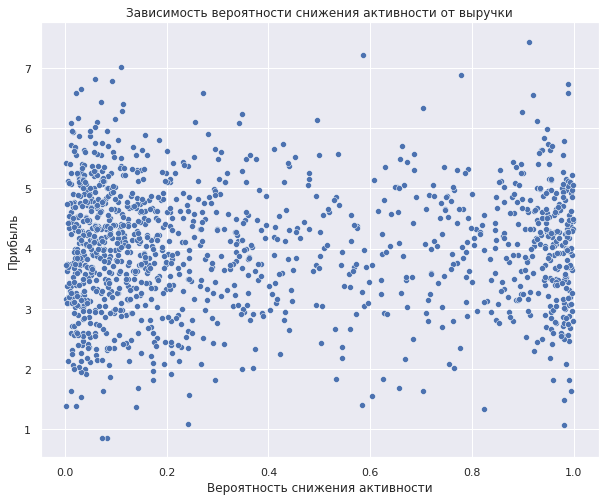

In [ ]:

fig = plt.figure(figsize=(10,8))
sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.title('Зависимость вероятности снижения активности от выручки')
plt.show()

Получили диаграмму рассеинья Прибыли и Вероятности снижения активности покупателя. Я не вижу зависимости вероятности снижения активности пользователя от прибыли.  
Посмотрим как ложатся категареальные признаки на подобную диаграмму.

In [ ]:
def build_scatterplots(cat_columns):
    for cat_col in cat_columns:
        fig = plt.figure(figsize=(10,8))
        sns.scatterplot(data=df_full, y='прибыль', x='вероятность_снижения', hue=cat_col)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.show()

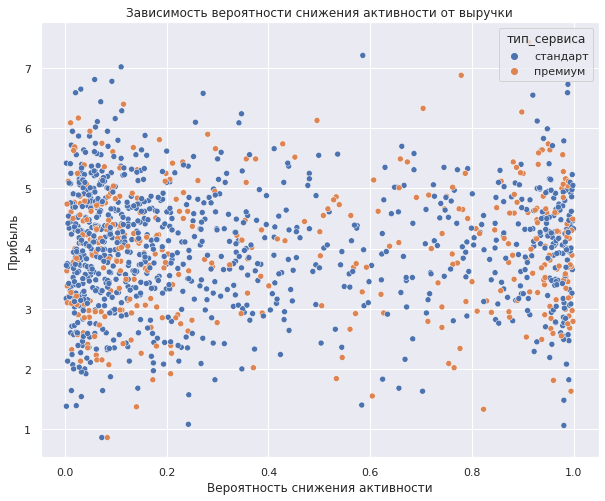

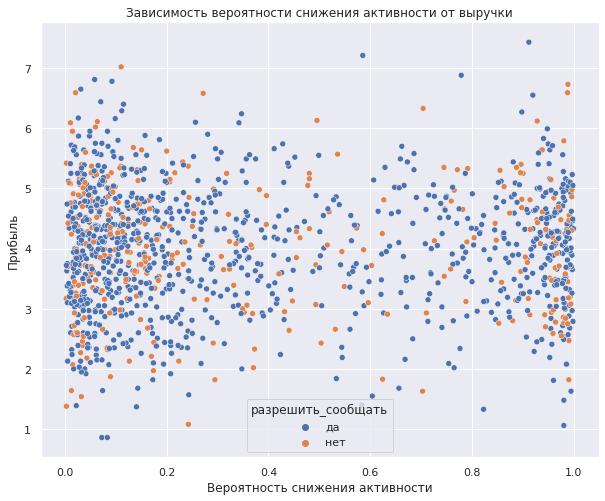

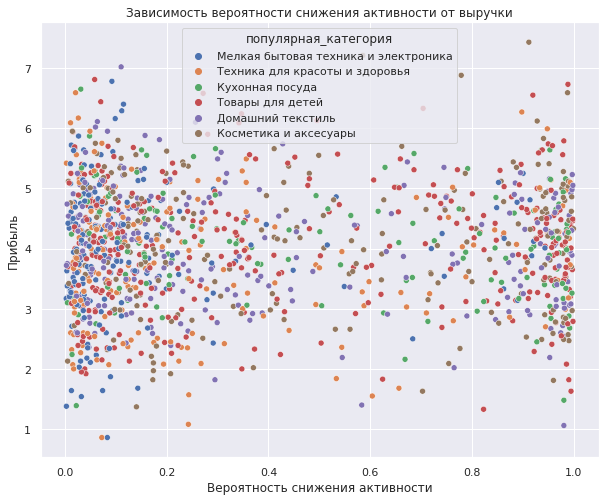

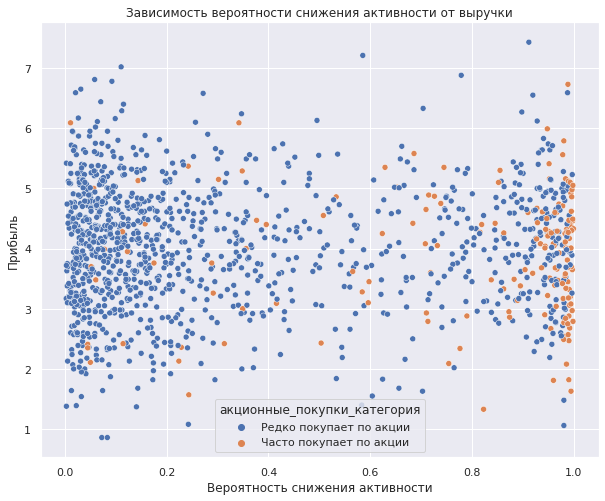

In [ ]:
cat_columns = list(df_full.select_dtypes(include='object').columns)
build_scatterplots(cat_columns)

По графикам больше всего бросается в глаза это распределение `Акционные_покупки_категория`. Пользователи, которые часто покупают по скидке чаще всего имеют высокую вероятность снижения активности. Это и понятно, скидки не постоянно бывают, значит и покупки этот сегмент пользователей совершает так сказать сезонно. И более того пользователи покупающие в основном по скидке прдставлены по всему распределению прибыли.

Что же попробуем проанализировать этот сегмент. Для этого добавим колонку и в ней промаркируем пользователей, которые часто покупают по акции и имеют вероятность снижения активности более 80%.

In [ ]:
df_full.head(4)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,акционные_покупки_категория,вероятность_снижения,прибыль
id,,,,,,,,,,,,,,,,,,
215858,стандарт,да,5.5,4,510,Мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20,6,Редко покупает по акции,0.066247,4.37
215361,стандарт,да,5.1,4,199,Техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11,13,Редко покупает по акции,0.780843,4.03
215884,стандарт,да,4.3,5,997,Мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13,10,Редко покупает по акции,0.083982,4.37
216564,стандарт,да,5.6,4,342,Кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,Часто покупает по акции,0.685967,5.58


In [ ]:
df_full['сегмент'] = df_full\
.apply( lambda row: 'Исследуемый сегмент' \
        if row['вероятность_снижения'] > 0.8 and row['акционные_покупки_категория']=='Часто покупает по акции' \
        else 'Остальные пользователи' \
      , axis=1)


array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Кухонная посуда', 'Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

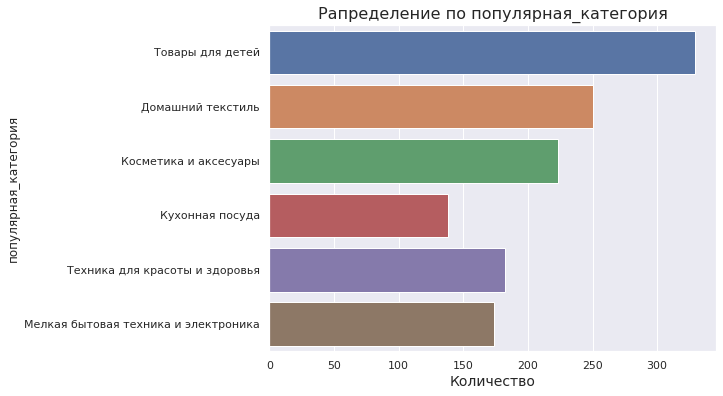

In [ ]:
categoral_unique(market_file, 'популярная_категория')

<div class="alert alert-info"> <b>Комментарии студентаV2:</b> Исправил
 </div>

Для меня это неожиданный результат. Для меня товары для детей это расходники. Если у тебя ребенок то траты постоянны. Но ладно мамы в декрете возможно и занимаются поиском скидок. 

array(['премиум', 'стандарт'], dtype=object)

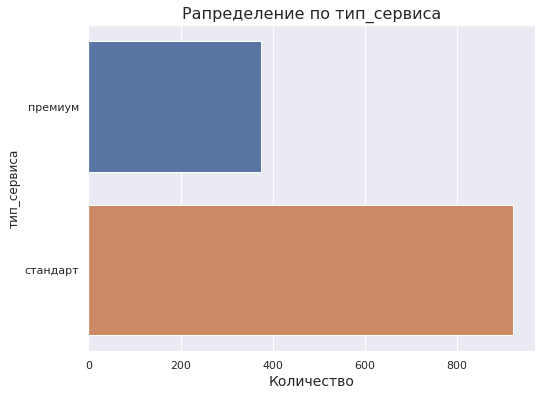

In [ ]:
categoral_unique(market_file, 'тип_сервиса')

Я перестал понимать людей. Человек покупает в основном по скидке, но в то же время покупает премиум. Что-то не сходится.  
И более того если сравнить распределения со всем массивом пользователей, но различие то невелико.

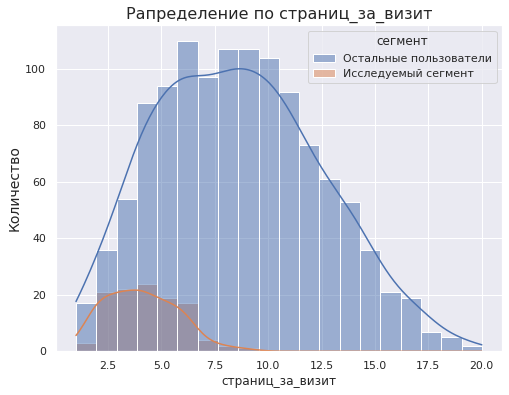

In [ ]:
histogram(df_full, 'страниц_за_визит', 'сегмент')

Видно по пользователи по скидке просматривают меньше страниц. Похоже на то что эти пользователи не ищут и выбирают, а покупают целенаправленно.

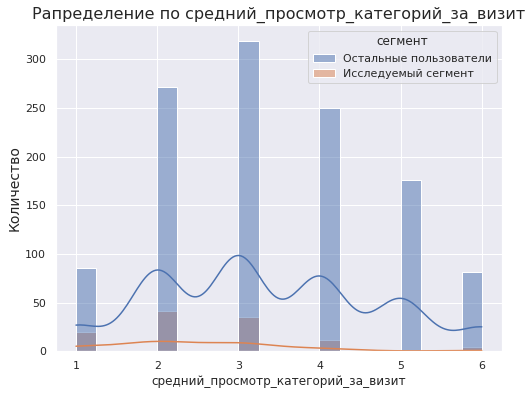

In [ ]:
histogram(df_full, 'средний_просмотр_категорий_за_визит', 'сегмент')

А в среднее кол-во просматриваемых категорий не различается.

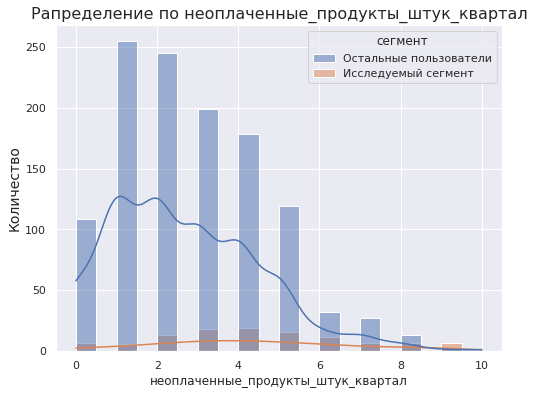

In [ ]:
histogram(df_full, 'неоплаченные_продукты_штук_квартал', 'сегмент')

Оказывается, что пользователи из иследуемого сегмента в среднем оставляют неоплаченными в корзине больше товаров. Для меня это неожиданный результат. Мне казалось, что это естественно накидывать в карзину уйму товаров, например на будущее, а покупать только некоторые.


Теперь сравним количество маркетинговых коммуникаций у покупателей по акции и всего массива пользователей. 

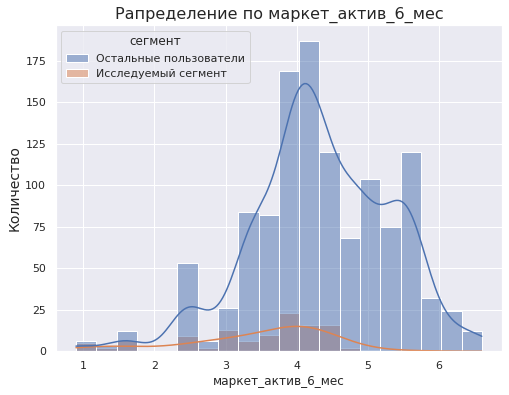

In [ ]:
histogram(df_full, 'маркет_актив_6_мес', 'сегмент')

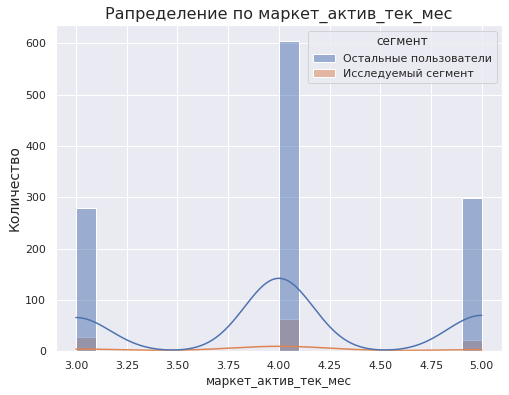

In [ ]:
histogram(df_full, 'маркет_актив_тек_мес', 'сегмент')

Ну что же покупатели по акции получали такое же количество внимания от маркетплейса как и все остальыне пользователи. Это значит что магазин не предоставляет им каких либо дополнительных источников получения информации о скидках. Все либо содержится в письмах, что получают все пользователи, либо на главной странице сайта.

Ну что же мы рассмотрели некоторые признаки сегмента пользователей, которые покупают по скидке и имеют высокую вероятность снижения покупательской активности.  
Попробуем описать его. Это пользователи, которые проводят не так много времени на сайте. Они не сравнивают товары, не выбирают лучший, они просмотривают один-два товара и покупают.  
Что же тогда можно предпринять что бы этот сегмент покупал больше, а значит приносил больше прибыли? Вот мои предложения.  
Не тратить средства на рассылки. Я не думаю, что человек, которые не хочет просматривать страницы с товарами будет просмотеривать рекламные материалы.  
Нужно соредоточиться на главной странице сайте тергетировать ее под конкретного покупателя. Нужно что бы скидка как можно чаще обновлялись на главной странице. Что бы у человека была всего одна страница, которую он может быстро пролистать и не ходить по страницам.

## Общий вывод

Задачей данного иссследования было построение модели, которая бы предсказала уменьшение покупательской активности пользователей интернет-магазина "В один клик".  
Другой задачей было исследование выбранного сегмента пользователей.

В рамках исследования были проделаны следующие шаги.  
  
#### Загрузка данных 

Исходными данными для исследования были четыре отдельных csv файла:
* с данными о поведении покупателя на сайте, коммуникации с ним и его продуктовом поведении. 
* с данными о выручке, которую получает магазин с покупателя за период
* с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
*  данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю
Данные были загружены в датафреймы библиотеки pandas.

#### Предобработка данных

Исходные данные оказались хорошего качества, но тем не менее они требовали проведения некоторых работ перед началом анализа.
Во-первых стандартизация имен признаков. Наименования были оставлены на кириллице, но пробелы были заменены на землю.  
Во-вторых приведение типов данных. Некоторые числовые значения были считанны как строковые.  
В-третих обработка дублей. Если не учитывать колонку с уникальным идентификатором, то в датасете `market_file` было найдено 11 дублей. Дубли было решено оставить.  
В-четвертых обработка пропусков. Пропусков в данных не было найдено.

#### Исследовательский анализ данных

На этом этапе были построены диаграммы распределения всех признаков. С помощью графиков были обнаружены и исправлены опечатки в категоральных признаках. Так же отметим, что график распределения признака `Акционные_покупки` явно выделял две группы пользователей поэтому признак был превращен в категориальный.

#### Корреляционный анализ данных

Целевым признаком является `Покупательская_активность` и вот список полей, которые имеют хоть корреляцию с ним: `Маркет_актив_6_мес`, `Акционные_покупки`, `Средний_просмотр_категорий_за_визит`, `Неоплаченные_продукты_штук_квартал`, `Страниц_за_визит`, `Выручка_препредыдущий_месяц`, `минут_предыдущий_месяц`, `минут_текущий_месяц`.  
Так же график показал сильную зависимость между целевым признаком и `id` так что в дальнейшем при подготовке данных к обучению модели признак идентификатор был удален.
Сильной корреляции между другими признаками не было выявлено поэтому все остальные признаки были оставленны в датасете.

#### Объеденение таблиц

Датасеты `market_file`, `market_money`, `market_time` были объеденены в один датафрейм.

#### Обучение модели

С использованием пайпланов из библиотеки sklearn были обучены модели KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). При обучении моделей средстави пайплана преебирались некоторое количество гиперпараметров моделей с целью нахождения модели, которая даст лучший результат.  
По результатам обучения лучшей стала модель `LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')`. Метрика roc_auc для тренеровочной выборки 0.90 для тестовой 0.89. Удивительно, но значения метрики имеют такой низкий разброс. И даже наличие дисбаланса в целевом признаке не помешало получить значение метрики f1=0.90.

#### Анализ важности признаков

Если коротко, то самыми важными оказались признаки связанные с количеством времени, которое покупатель проводит на меркет плейсе. А наименее важными, категории товаров, котоыре интересовали пользователи и комменикации с пользователем.  
Кажется что все эти маркетинговые завлекаловки и спам на почту не помогают маркетплейсу. Важно лишь заставить пользователя проводить на сайте как можно больше времени и продажи выростут.

#### Сегментация пользователей

Для анализа пользователей был выбран сегмент пользователей часто покупающих по скидке и в то же время имеющийх высокую вероятность снижения покупательской активности. Мое предложение по увеличение актвности этого сегмента покупателей это таргетированная настройка главной страницы маркетплейса. А так же более частое обновление скидок на главной странице. Пользователь не хочет ходить по страницам, он хочет видеть все предложения в одном месте. 

Здравствуйте, понимаю что менять структуру проекта неприемленно, но мне казалось что он выглядит неопрятно.

вопрос: можите скинуть ссылку на гайд как делать `<div class="alert alert-info">` а то в гайде на формать Md на Github не сказано

заранее спасибо и извините за неудобства.